In [39]:
from difflib import SequenceMatcher
import string
import numpy as np
import re

In [40]:
import pandas as pd

In [41]:
df = pd.read_csv('/kaggle/input/bengali-ged/DataSetFold1_u.csv')

In [42]:
# types of error per token

# spanning error, begin+end, easy to decode, replace $ at end or begin, 7632

# one word error, tricky with punctuation 7057, how to replace $$, place before punctuation, 8482

# insertion error, $$ with punctuation, replace $$, always at the end? 5202, 2 type, 

# deletion error, always at the end?, 5548

tags def

**one word error**, look at begin dollar or look for end dollar, decode: replace with dollar accordingly

**insertion error**, $$ with punctiation, decode: replace dollar at the end

**deletion error**, $$ with empty, decode: replace dollar at the end

**multiple error**, not sure how to handle this

In [43]:
puncs = [item for item in string.punctuation if item!='$']+['।','"']

In [44]:
puncs

['!',
 '"',
 '#',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~',
 '।',
 '"']

In [45]:
np.random.seed(42)
# encode
sentence_labels = []
label_broken = [] 
for ind in range(50):
    print('==============================================================')
    ind  = np.random.randint(0,len(df))
    print(ind)
    # ind = 9071
    source_sent = df.sentence[ind]
    target_sent = df['gt'][ind]
    print('sentence:', source_sent)
    print('gt:',target_sent)
    source_tokens = source_sent.split()
    target_tokens = target_sent.split()
    matcher = SequenceMatcher(None, source_tokens, target_tokens)
    diffs = list(matcher.get_opcodes())
    all_edits = []
#     print(source_tokens, target_tokens)
    labels_token = []
    for diff in diffs:
        tag, i1, i2, j1, j2 = diff
        print('----------------------------------------------------')
#         print(diff)
#         print(source_tokens[i1:i2], target_tokens[j1:j2], tag)
        if tag != 'equal':
            for s_t, t_t in zip(source_tokens[i1:i2], target_tokens[j1:j2]):
                label = None
                dollars = re.findall('[$]', t_t)
                # label begin/end error
                if len(dollars)==1:
                    #remove punc before searching
                    t_t_no_punc = ''.join([s for s in t_t if s not in puncs])

                    if t_t_no_punc[0] == '$':
                        label = 'begin_err'
                    if t_t_no_punc[-1] == '$':
                        label = 'end_err'
                    
                # label one word error/insertion/deletion
                if len(dollars) == 2:
    #                 span = re.search('(\$.?\$)+',t_t).span()
                    span = re.search('\$.*?\$',t_t).span()
                    _string = t_t[span[0]:span[1]].replace('$','')
    #                 print(string)
                    if len(_string)==0:
                        label = 'del_err'
                    else:
                        if np.all([s in puncs for s in _string]):
                            label = 'punc_insert_err'
                        else:
                            label = 'one_word_err'
                # multiple error
                if len(dollars) == 4:
                    label = '2_err'
                if len(dollars) == 3:
                    label = '1-5_err'
                print(t_t, label)
                labels_token.append(label)
                if label in ['2_err', '1-5_err', None]:
                    print('label',label, t_t, ind)  
                
        else:
            for s_t, t_t in zip(source_tokens[i1:i2], target_tokens[j1:j2]):
                label = '0'
                print(t_t, label)
                labels_token.append(label)
    if len(source_tokens) != len(labels_token):
        label_broken.append(True)
    else:
        label_broken.append(False)
    sentence_labels.append(labels_token)



7270
sentence: বর্তমানে আইন কমিশন একজন চেয়ারম্যান ও দুজন সদস্য সমন্বয়ে গঠিত।
gt: বর্তমানে আইন কমিশন একজন চেয়ারম্যান ও দুজন সদস্য সমন্বয়ে গঠিত।
----------------------------------------------------
বর্তমানে 0
আইন 0
কমিশন 0
একজন 0
চেয়ারম্যান 0
ও 0
দুজন 0
সদস্য 0
সমন্বয়ে 0
গঠিত। 0
860
sentence: হিতোশি সাকামোতো এই সংস্করণের অডিওর জন্য দায়ী ছিলেন।
gt: হিতোশি সাকামোতো$$ এই সংস্করণের অডিওর জন্য দায়ী ছিলেন।
----------------------------------------------------
হিতোশি 0
----------------------------------------------------
সাকামোতো$$ del_err
----------------------------------------------------
এই 0
সংস্করণের 0
অডিওর 0
জন্য 0
দায়ী 0
ছিলেন। 0
5390
sentence: ঘুম থেকে আমাদের ওঠানো হতো।
gt: ঘুম থেকে আমাদের ওঠানো হতো।
----------------------------------------------------
ঘুম 0
থেকে 0
আমাদের 0
ওঠানো 0
হতো। 0
5191
sentence: নিজেকে একজন সাধারণ মানুষ ভেবে সবার সঙ্গে মিশে একসঙ্গে কাজ করতেন।
gt: নিজেকে একজন সাধারণ মানুষ ভেবে সবার সঙ্গে মিশে একসঙ্গে কাজ করতেন।
------------------------------------------

In [46]:
import Levenshtein

In [47]:
Levenshtein.distance('qweert','232qwer')

5

In [48]:
from tqdm.notebook import tqdm

In [49]:
# np.random.seed(42)
# encode
sentence_labels = []
label_broken = [] 
for ind in range(len(df)):
#     print('==============================================================')
#     ind  = np.random.randint(0,len(df))
#     print(ind)
    # ind = 9071
    source_sent = df.sentence[ind]
    target_sent = df['gt'][ind]
#     print('sentence', source_sent)
#     print('gt',target_sent)
    source_tokens = source_sent.split()
    target_tokens = target_sent.split()
    matcher = SequenceMatcher(None, source_tokens, target_tokens)
    diffs = list(matcher.get_opcodes())
    all_edits = []
#     print(source_tokens, target_tokens)
    labels_token = []
    for diff in diffs:
        tag, i1, i2, j1, j2 = diff
#         print('----------------------------------------------------')
#         print(diff)
#         print(source_tokens[i1:i2], target_tokens[j1:j2], tag)
        if tag != 'equal':
            for s_t, t_t in zip(source_tokens[i1:i2], target_tokens[j1:j2]):
                label = None
                dollars = re.findall('[$]', t_t)
                # label begin/end error
                if len(dollars)==1:
                    #remove punc before searching
                    t_t_no_punc = ''.join([s for s in t_t if s not in puncs])

                    if t_t_no_punc[0] == '$':
                        label = 'begin_err'
                    if t_t_no_punc[-1] == '$':
                        label = 'end_err'
                    
                # label one word error/insertion/deletion
                if len(dollars) == 2:
    #                 span = re.search('(\$.?\$)+',t_t).span()
                    span = re.search('\$.*?\$',t_t).span()
                    _string = t_t[span[0]:span[1]].replace('$','')
    #                 print(string)
                    if len(_string)==0:
                        label = 'del_err'
                    else:
                        if np.all([s in puncs for s in _string]):
                            label = 'punc_insert_err'
                        else:
                            label = 'one_word_err'
                # multiple error
                if len(dollars) == 4:
                    label = '2_err'
#                 print(t_t, label)
                if len(dollars) == 3:
                    label = '1-5_err'
#                 print(t_t, label)
                labels_token.append(label)
                if label in [None]:
                    print('label',label, t_t, ind)  
                

        else:
            for s_t, t_t in zip(source_tokens[i1:i2], target_tokens[j1:j2]):
                label = '0'
#                 print(t_t, label)
                labels_token.append(label)
    if len(source_tokens) != len(labels_token):
        label_broken.append(True)
    else:
        label_broken.append(False)
    sentence_labels.append(labels_token)



label None $হইছে$$,$$আরো$ 96
label None সবজি$,$হালুয়া$,$ডাল$,$দই 1146
label None থাইল্যান্ড$,$মালয়েশিয়া$,$চায়না$,$কোরিয়া$,$জাপান 1641
label None শয়তান$,$ইবলিশ$,$নরপিশাচ$,$শুয়ার$,$কুত্তা$,$অমানুষ$ 1956
label None জনাব$_$ইসমাইল$_$চৌধুরী$_$সম্রাট 3601
label None কোন$াে 4282
label None বিরোধী$আন্দোলন 4980
label None $করেনা$$,$$অনেক 4987
label None টা$দেখবা 5888
label None তে$তার 7563
label None কোন$টা 7848
label None কোন$টা 7848
label None কোন$মতেই 8306


In [50]:
df['sentence'][8306], df['gt'][8306]

('মতামতের জন্য কবি কোনমতেই দায়ী নয় এবং সেক্ষেত্রে মহামান্য এডমিনের সিদ্ধান্ত চুড়ান্ত বলে বিবেচিত হবে।',
 'মতামতের জন্য কবি$ কোন$মতেই দায়ী নয় এবং সেক্ষেত্রে মহামান্য এডমিনের সিদ্ধান্ত চুড়ান্ত বলে বিবেচিত হবে।')

In [51]:
sum(label_broken), len(label_broken)

(1, 9380)

In [52]:
df['sentence_labels'] = sentence_labels
df['source_tokens'] = df.sentence.apply(lambda x: x.split())

# df_filtered =df[]
df_filtered = df[np.logical_and(
    [None  not in sl for sl  in sentence_labels],
    np.logical_not(label_broken)
)]

In [53]:
flat_list = [item for sublist in df_filtered.sentence_labels for item in sublist]


In [54]:
import matplotlib.pyplot as plt

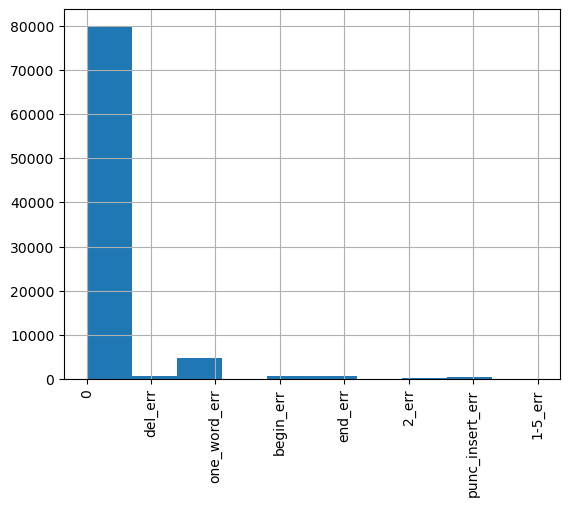

In [55]:
pd.Series(flat_list).hist()
_=plt.xticks(rotation = 90)

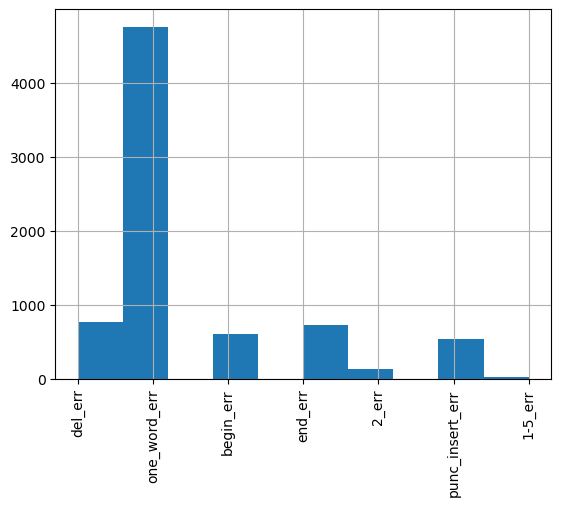

In [56]:
pd.Series([l for l in flat_list if l!='0']).hist()
_=plt.xticks(rotation = 90)

In [57]:
# #decode
# # np.random.seed(42)
# # encode
# distance = 0
# df_filter = df[np.logical_not(label_broken)]
# for ind in df_filter.index:
# #     print('==============================================================')
# #     ind  = np.random.randint(0,len(df))
# #     print(ind)
#     # ind = 9071
#     source_sent = df_filter.sentence[ind]
#     target_sent = df_filter['gt'][ind]
#     source_tokens = source_sent.split()
#     labels_token = df_filter['sentence_labels'][ind]
#     pred_tokens = []
#     for s_t, lbl in zip(source_tokens, labels_token):
#         prd = None
#         if lbl == 'begin_err':
#             prd = '$'+s_t
#         if lbl == 'end_err':
#             prd = s_t+'$'
#         if lbl == 'del_err':
#             prd = s_t+'$$'
#         if lbl == 'punc_insert_err':
#             prd = s_t+'$$'
#         if lbl == '2_err':
#             prd = '$'+s_t+'$$$'
#         if lbl == '1-5_err':
#             prd = s_t+'$$$'
#         if lbl == 'one_word_err':
#             prd = '$'+s_t+'$'
#         if lbl== 0:
#             prd = s_t
#         if lbl is None:
#             prd = s_t
#         if prd is None:
#             print(lbl)
#         pred_tokens.append(prd)
#     pred_sent = ' '.join(pred_tokens)
#     distance+=Levenshtein.distance(pred_sent, target_sent)
# #     print('sentence', source_sent)
# #     print('gt',target_sent)
    
# #     target_tokens = target_sent.split()
# print(distance/len(df_filter))

In [58]:
from sklearn.model_selection import train_test_split

In [59]:
df_train, df_test = train_test_split(df_filtered, test_size = 0.05, random_state=42)

In [60]:
train_list = [{'tokens': x, 'tags': y} for x,y in zip(df_train.source_tokens,df_train.sentence_labels)]
test_list = [{'tokens': x, 'tags': y} for x,y in zip(df_train.source_tokens,df_train.sentence_labels)]

In [82]:
train_list[8]

{'tokens': ['অত্যন্ত',
  'সাবধান',
  'লোকেরও',
  'সাবধানতায়',
  'ত্রুটি',
  'থাকিয়া',
  'যায়।'],
 'tags': ['0', '0', '0', '0', '0', 'one_word_err', '0']}

In [61]:
# !rm -r banglabert/

In [62]:
# !rm -r outputs/

In [63]:
!git clone https://github.com/Reasat/banglabert.git

Cloning into 'banglabert'...
remote: Enumerating objects: 158, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 158 (delta 82), reused 71 (delta 23), pack-reused 0
Receiving objects: 100% (158/158), 1.11 MiB | 4.25 MiB/s, done.
Resolving deltas: 100% (82/82), done.


In [64]:
!pip install seqeval==1.2.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 549.0 kB/s eta 0:00:00 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16179 sha256=68d3b431bdae00bde5e5e41b65ab33f0462d47d3627f36c42f566f38af16ba58
  Stored in directory: /root/.cache/pip/wheels/b2/a1/b7/0d3b008d0c77cd57332d724b92cf7650b4185b493dc785f00a
Successfully built seqeval


In [65]:
!pip install git+https://github.com/csebuetnlp/normalizer

  Cloning https://github.com/csebuetnlp/normalizer to /tmp/pip-req-build-6nj0s14g
  Running command git clone --filter=blob:none --quiet https://github.com/csebuetnlp/normalizer /tmp/pip-req-build-6nj0s14g
  Resolved https://github.com/csebuetnlp/normalizer to commit d80c3c484e1b80268f2b2dfaf7557fe65e34f321
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 1.3 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for normalizer: filename=normalizer-0.0.1-py3-none-any.whl size=6883 sha256=f787a3aa73be04015bc93d468f0f256f9a776ecf6d9e07ee53f5b7867c34ed03
  Stored in directory: /tmp/pip-ephem-wheel-cache-pn5m8cef/wheels/af/b1/ee/b9e2a2f2dd861976a357b6a6fa105aeedf2254016676f6cf8f
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186469 sha256=745af19fc48f5baed139e75b24602e6

In [66]:
'O' == '0'

False

In [67]:
import json
with open("banglabert/token_classification/sample_inputs/train.jsonl", 'w') as f:
    for item in train_list:
        f.write(json.dumps(item) + "\n")

with open("banglabert/token_classification/sample_inputs/validation.jsonl", 'w') as f:
    for item in test_list:
        f.write(json.dumps(item) + "\n")

with open("banglabert/token_classification/sample_inputs/test.jsonl", 'w') as f:
    for item in test_list:
        f.write(json.dumps(item) + "\n")

In [ ]:
!python banglabert/token_classification/token_classification.py \
    --model_name_or_path "csebuetnlp/banglabert" \
    --dataset_dir "banglabert/token_classification/sample_inputs/" \
    --output_dir "outputs/" \
    --learning_rate=2e-5 \
    --warmup_ratio 0.1 \
    --gradient_accumulation_steps 2 \
    --weight_decay 0.1 \
    --lr_scheduler_type "linear"  \
    --per_device_train_batch_size=16 \
    --per_device_eval_batch_size=16 \
    --max_seq_length 512 \
    --logging_strategy "epoch" \
    --save_strategy "epoch" \
    --save_total_limit 1 \
    --evaluation_strategy "epoch" \
    --num_train_epochs=30 --do_train --do_eval

In [ ]:
abul = pd.read_csv('/kaggle/input/bengali-ged/SampleSubmission.csv')

In [ ]:
test_list_kaggle = [{'tokens': item.split(), 'tags': ['0']*len(item.split())} for item in abul.Expected]
with open("banglabert/token_classification/sample_inputs/test.jsonl", 'w') as f:
    for item in test_list_kaggle:
        f.write(json.dumps(item) + "\n")

In [ ]:
!python banglabert/token_classification/token_classification.py \
    --model_name_or_path outputs/\
    --dataset_dir "banglabert/token_classification/sample_inputs/" \
    --output_dir "banglabert/token_classification/outputs_eval/" \
    --per_device_eval_batch_size=16 \
    --overwrite_output_dir \
    --do_predict

In [ ]:
with open("banglabert/token_classification/outputs_eval/predictions.txt",'r') as f:
    preds = f.readlines()
#     preds =  for l in preds

In [ ]:
# for x,y in zip(abul.Expected,preds):
#     source_tokens = x.split()
#     labels = y.split()
#     print('============================================================================')
#     for a,b in zip(source_tokens, labels):
#         print(a,b)

In [ ]:
#decode
# np.random.seed(42)
# encode
preds_all = []
for x,y in zip(abul.Expected,preds):
#     print('==============================================================')
#     ind  = np.random.randint(0,len(df))
#     print(ind)
    # ind = 9071
    source_sent = x
    source_tokens = source_sent.split()
    labels = y.split()
    pred_tokens = []
    for s_t, lbl in zip(source_tokens, labels):
        prd = None
        if lbl == 'begin_err':
            prd = '$'+s_t
        if lbl == 'end_err':
            prd = s_t+'$'
        if lbl == 'del_err':
            prd = s_t+'$$'
        if lbl == 'punc_insert_err':
            prd = s_t+'$$'
        if lbl == '2_err':
            prd = '$'+s_t+'$$$'
        if lbl == '1-5_err':
            prd = s_t+'$$$'
        if lbl == 'one_word_err':
            prd = '$'+s_t+'$'
        if lbl== '0':
            prd = s_t
        if lbl is None:
            prd = s_t
        if prd is None:
            print(lbl)
        pred_tokens.append(prd)
#         print(pred_tokens)
    pred_sent = ' '.join(pred_tokens)
    print('sentence', source_sent)
    print('pred',pred_sent)
    preds_all.append(pred_sent)
#     target_tokens = target_sent.split()
# print(distance/len(df_filter))

In [ ]:
df_pred = abul.copy()
df_pred.Expected = preds_all
df_pred.to_csv('submission.csv', index = False)